In [134]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

In [157]:
data = pd.read_csv('../resources/data/cardio/cardio_train.csv', sep=';')

### Cardiovascular Disease dataset
https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [158]:
print(data.shape)
print(1. * np.sum(data['cardio']) / data.shape[0])

(70000, 13)
0.4997


In [159]:
data['bmi'] = data['weight'] / (.01 * data['height'])**2
data['age_in_years'] = data['age'] / 365

# norms = pd.read_csv('../resources/data/cardio/cardio_norms.csv')

# def ap_score(norms, x):
#     age, gender, ap_hi, ap_lo = x['age_in_years'], x['gender'], x['ap_hi'], x['ap_lo']
#     gender -= 1
#     norm = norms[(age >= norms['min_age']) & (age < norms['max_age']) & (gender == norms['gender'])]
#     good_ap_hi, good_ap_lo = int(norm['ap_hi']), int(norm['ap_lo'])
#     return (1. - np.abs(good_ap_hi - ap_hi) / good_ap_hi) * (1. - np.abs(good_ap_lo - ap_lo) / good_ap_lo)
    
# data['ap_score'] = data.apply(lambda x: ap_score(norms, x), axis=1)

data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_in_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,50.391781
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,55.419178
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,51.663014
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,48.282192
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,47.873973


### Train a feed forward network

In [160]:
ordinal = ['age_in_years', 'ap_hi', 'ap_lo', 'bmi']
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
target = 'cardio'
X, y = data[ordinal + categorical], data[target]

In [161]:
from sklearn.model_selection import train_test_split

# val dataset in GridSearchCV
train_ratio, test_ratio, target_ratio = .8, .1, .1

test_and_target = test_ratio + target_ratio
op_train_ratio = 1. - train_ratio

X_train, X_heldout, y_train, y_heldout = train_test_split(X, y, test_size=op_train_ratio)
X_test, X_target, y_test, y_target = train_test_split(X_heldout, y_heldout, test_size=target_ratio / test_and_target)

# to check if this stuff works correctly :)
# to_check = data['id']
# to_check_train, to_check_heldout = train_test_split(to_check, test_size=op_train_ratio)
# to_check_val, to_check_tmp = train_test_split(to_check_heldout, test_size=test_and_target / op_train_ratio)
# to_check_test, to_check_target = train_test_split(to_check_tmp, test_size=target_ratio / test_and_target)
# check = np.concatenate([to_check_train, to_check_test, to_check_val, to_check_target])
# print(check.shape[0] == np.unique(check).shape[0])

### GridSearch + Pipeline + keras feed-forward NN

In [162]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

feature_transformation = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaled_numeric', StandardScaler(), ordinal)
])

def create_model(size_1, size_2):
    nn = keras.Sequential([
        keras.layers.Dense(size_1, activation=tf.nn.relu),
        keras.layers.Dense(size_2, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    nn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return nn

model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)

pipeline = Pipeline([('transformers', feature_transformation), ('estimator', model)])

params = {
    'estimator__epochs': [50],
    'estimator__batch_size': [1024],
    'estimator__size_1': [4, 8, 16],
    'estimator__size_2': [4, 8],
    'estimator__verbose': [0]
}

clf = GridSearchCV(pipeline, params, cv=5, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('categorical_features', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
 ...timator', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7feaa2bebf98>)]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__epochs': [50], 'estimator__batch_size': [1024], 'estimator__size_1': [4, 8, 16], 'estimator__size_2': [4, 8], 'estimator__verbose': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [163]:
score_on_train_data = accuracy_score(y_train, clf.predict(X_train))
score_on_noncorrupted_test_data = accuracy_score(y_test, clf.predict(X_test))
score_on_noncorrupted_target_data = accuracy_score(y_target, clf.predict(X_target))

print("score on train data: ", score_on_train_data)
print("score on test data: ", score_on_noncorrupted_test_data)
print("score on target data: ", score_on_noncorrupted_target_data)

score on train data:  0.7347857142857143
score on test data:  0.7352857142857143
score on target data:  0.7381428571428571


### Introduce errors (missing values) into unseen test data, record resulting class probability entropies and accuracy score as inputs for the meta regressor

In [164]:
from copy import deepcopy

mask = lambda x: (x['age_in_years'] > 50.) & (x['bmi'] > 25.)

def corrupt(X, mask):
    corrupted_X = deepcopy(X)
    corrupted_X['cholesterol'][mask(X)] = 3
    corrupted_X['active'][mask(X)] = 0
    # corrupted_X['weight'][X['weight'] > 90.] = np.nan
    return corrupted_X

# corrupting the data, conditions
corrupted_X_test = corrupt(X_test, mask)
score_on_corrupted_test_data = accuracy_score(y_test, clf.predict(corrupted_X_test))

print("score on corrupted test data: ", score_on_corrupted_test_data)

score on corrupted test data:  0.6968571428571428


### Plot AUC ROC curve
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

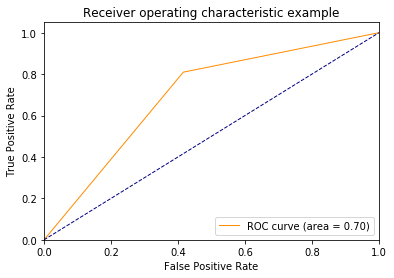

In [165]:
from sklearn.metrics import roc_curve, auc

predicted = clf.predict(corrupted_X_test)
# predicted_proba = clf.predict_proba(corrupted_X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = np.unique(y).shape[0]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predicted)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 1

plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# import scikitplot as skplt

# skplt.metrics.plot_roc_curve(y_test, predicted_proba)
# plt.show()

### Fit a simple regression model to the generated training data

In [200]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import entropy

regressor_X_train = []
regressor_y_train = []

dataset_size_for_regressor = 500

def quant(percent): return lambda x: np.percentile(x, percent)

def stats(data):
    funcs = [np.min, np.max, np.mean, np.std, quant(25), quant(50), quant(75)]
    for column in data.T:
        for foo in funcs:
            yield foo(column)

def create_dataset_for_regressor(clf, X, y, size, mask):
    regressor_X, regressor_y = [], []
    for i in np.random.random_integers(1, 1000, size):
        np.random.seed(i)
        corrupted_data = deepcopy(X)
        new_mask = deepcopy(mask)
        factor = int(round(np.random.random() * values_to_change))
        new_mask.loc[np.random.choice(mask[mask == True].index, factor, replace=False)] = False
        corrupted_data['cholesterol'][new_mask] = 3
        regressor_X.append(list(stats(clf.predict_proba(corrupted_data))))
        regressor_y.append(accuracy_score(y, clf.predict(corrupted_data)))
    np.random.seed(1)
    return regressor_X, regressor_y

regressor_X_train, regressor_y_train = create_dataset_for_regressor(clf, X_test, y_test, 100, mask(X_test))

meta_regressor = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', LinearRegression())
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('learner', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### Evaluate regression model in predicting effects of errors in the unseen target data

In [201]:
regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, mask(X_target))

In [202]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

predicted_target = meta_regressor.predict(regressor_X_target)
predicted_train = meta_regressor.predict(regressor_X_train)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

score on corrupted target data:  0.004362158518512836


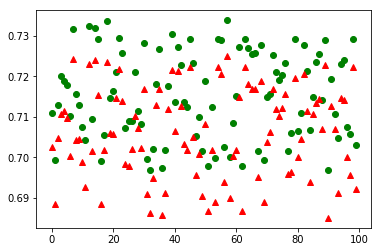

In [203]:
plt.plot(range(len(regressor_y_train)), regressor_y_train, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()

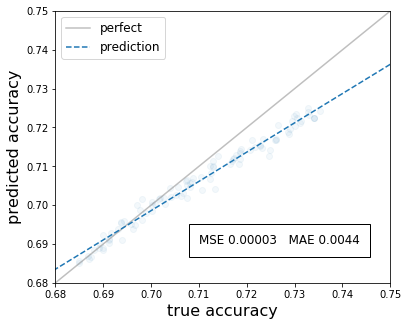

In [204]:
import scipy.stats

true_scores = regressor_y_target
predicted_scores = predicted_target

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.6, 0.82, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.68, 0.75))
plt.ylim((0.68, 0.75))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(.71, .69, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/cardio-lr.pdf', dpi=300)
plt.show()

In [205]:
from sklearn.ensemble import RandomForestRegressor

meta_regressor = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', RandomForestRegressor())
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, mask(X_target))

score on corrupted target data:  0.0044445423469387825


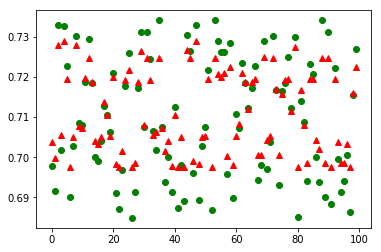

In [206]:
predicted_target = meta_regressor.predict(regressor_X_target)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

plt.plot(range(len(regressor_y_target)), regressor_y_target, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()

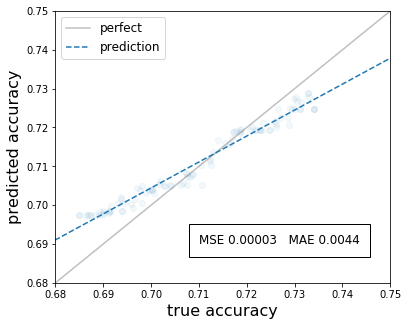

In [207]:
import scipy.stats

true_scores = regressor_y_target
predicted_scores = predicted_target

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.6, 0.82, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.68, 0.75))
plt.ylim((0.68, 0.75))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(.71, .69, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/cardio-rf.pdf', dpi=300)
plt.show()

In [208]:
from sklearn.neighbors import KNeighborsRegressor

meta_regressor = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', KNeighborsRegressor(n_neighbors=20))
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, mask(X_target))

score on corrupted target data:  0.005477571428571427


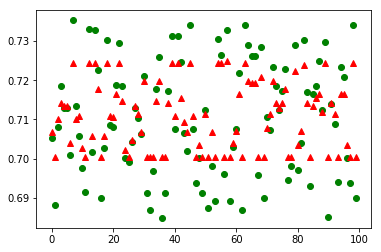

In [209]:
predicted_target = meta_regressor.predict(regressor_X_target)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

plt.plot(range(len(regressor_y_target)), regressor_y_target, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()

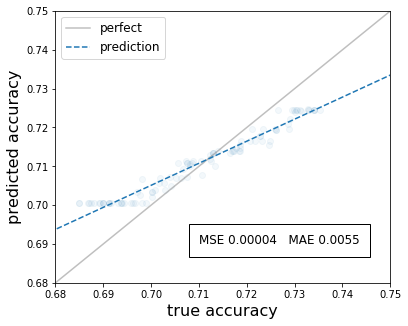

In [210]:
import scipy.stats

true_scores = regressor_y_target
predicted_scores = predicted_target

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.6, 0.82, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.68, 0.75))
plt.ylim((0.68, 0.75))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(.71, .69, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/cardio-knn.pdf', dpi=300)
plt.show()

In [211]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression

meta_regressor = Pipeline([
    ('scaling', StandardScaler()), 
    ('embeddings', RandomTreesEmbedding(max_depth=3, n_estimators=10, random_state=0)),
    ('learner', LinearRegression())
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, mask(X_target))

score on corrupted target data:  0.005020574925099387


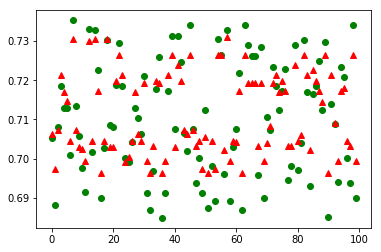

In [212]:
predicted_target = meta_regressor.predict(regressor_X_target)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

plt.plot(range(len(regressor_y_target)), regressor_y_target, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()

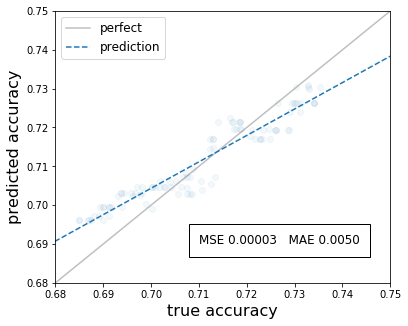

In [213]:
import scipy.stats

true_scores = regressor_y_target
predicted_scores = predicted_target

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.6, 0.82, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.68, 0.75))
plt.ylim((0.68, 0.75))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(.71, .69, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/cardio-rt-lr.pdf', dpi=300)
plt.show()

In [214]:
from sklearn.ensemble import RandomForestRegressor

meta_regressor = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', RandomForestRegressor(criterion='mae'))
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, mask(X_target))

score on corrupted target data:  0.004557857142857146


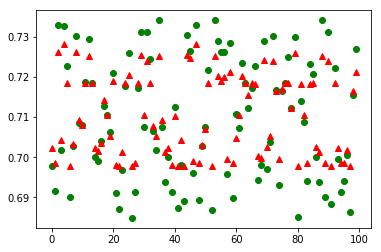

In [215]:
predicted_target = meta_regressor.predict(regressor_X_target)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

plt.plot(range(len(regressor_y_target)), regressor_y_target, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()

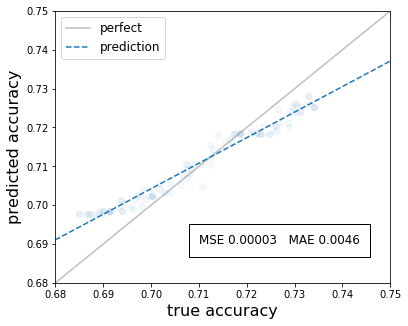

In [216]:
import scipy.stats

true_scores = regressor_y_target
predicted_scores = predicted_target

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.6, 0.82, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.68, 0.75))
plt.ylim((0.68, 0.75))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(.71, .69, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/cardio-rf-mae.pdf', dpi=300)
plt.show()